## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
test set of say, 128 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
SIGNS = [-1., 1.] 

ORTHANTS = torch.stack(
    [torch.tensor([s1, s2, s3, s4, s5, s6, s7])
    for s1 in SIGNS
    for s2 in SIGNS
    for s3 in SIGNS
    for s4 in SIGNS
    for s5 in SIGNS
    for s6 in SIGNS
    for s7 in SIGNS])   # Representing each orthant as the sign of each of its 7 coordinates/wrt each of its 7 axes
ORTHANTS.shape

torch.Size([128, 7])

In [3]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 64 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Fraction of "rare" orthants
ZERO_FRAC = 0.25    # Fraction of empty orthants from rare orthants

In [4]:
# HIGH_ORTHANTS, LOWER_ORTHANTS = train_test_split(ORTHANTS, test_size=LOW_FRAC)
# # Randomly choosing the "rare" orthants
# LOW_ORTHANTS, ZERO_ORTHANTS = train_test_split(LOWER_ORTHANTS, test_size=ZERO_FRAC)
# HIGH_ORTHANTS.shape, LOW_ORTHANTS.shape, ZERO_ORTHANTS.shape

HIGH_ORTHANT_INDICES, LOWER_ORTHANT_INDICES = train_test_split(np.arange(128), test_size=LOW_FRAC)
LOW_ORTHANT_INDICES, ZERO_ORTHANT_INDICES = train_test_split(LOWER_ORTHANT_INDICES, test_size=ZERO_FRAC)
HIGH_ORTHANT_INDICES.shape, LOW_ORTHANT_INDICES.shape, ZERO_ORTHANT_INDICES.shape

((96,), (24,), (8,))

In [5]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [6]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Now, we describe a 7-sphere using the standard notation. <br>
Say, it is centered at $C = (C_1, C_2, ..., C_7)$ and has radius $r$. Each point can be described with the help of 6 angles, <br>
$\phi_1$, $\phi_2$, $\phi_3$, $\phi_4$, $\phi_5$, and $\phi_6$, where $\phi_6 \in [0, 2\pi)$ and $\phi_1, ..., \phi_5 \in [0, \pi]$ <br>
Any point $x = (x_1, x_2, ..., x_7)$ on the sphere can be described as follows: <br>
$x_1 = C_1 + r\cos(\phi_1)$ <br>
$x_2 = C_2 + r\sin(\phi_1)\cos(\phi_2)$ <br>
$x_3 = C_3 + r\sin(\phi_1)\sin(\phi_2)\cos(\phi_3)$ <br>
$x_4 = C_4 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\cos(\phi_4)$ <br>
$x_5 = C_5 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\cos(\phi_5)$ <br>
$x_6 = C_6 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\cos(\phi_6)$ <br>
$x_7 = C_7 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\sin(\phi_6)$
<br>

Hence, each datapoint will be sampled by randomly generating the 6 angles from appropriate uniform distributions and 
performing the mentioned transformation

In [7]:
def generate_point(
    radius: float,
    orthant: torch.Tensor
) -> torch.Tensor:
    """
    Generates a point on a 7-sphere of centre orthant * CENTRE (global) with radius radius, where
    orthant denotes the signs wrt all 7 axes

    Args:
        radius (float): radius of the 7-sphere
        orthant (torch.Tensor): signs wrt the 7 axes for the resulting point, of shape (7,)
    
    Returns:
        x (torch.Tensor): a point on the specified sphere, of shape (7,)
    
    Example usage:
    >>> generate_point(2, tensor([1., 1., 1., 1., 1., 1., 1.]))
    tensor([2., 4., 4., 4., 4., 4., 4.])
    """
    phi = torch.rand((6,)) * torch.pi
    phi[5] *= 2
    diff_unit = torch.tensor([
        torch.cos(phi[0]),
        torch.sin(phi[0])*torch.cos(phi[1]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.cos(phi[2]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.cos(phi[3]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.cos(phi[4]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.cos(phi[5]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.sin(phi[5])
    ])
    return torch.mul(CENTRE + radius * diff_unit, orthant)
    

In [8]:
# Testing correctness

random_point = generate_point(2, ORTHANTS[0])
random_point, ((random_point - ORTHANTS[0]*CENTRE)**2).sum().sqrt()

(tensor([-3.1439, -4.9384, -2.7714, -4.7471, -3.5062, -3.7271, -4.0244]),
 tensor(2.0000))

In [9]:
from numpy.random import choice

elements = [-1., 1.]
probas = [0.2, 0.8]

FLIP_MULS = choice(a=elements, size=128, p=probas)
FLIP_MULS[FLIP_MULS==-1].shape, FLIP_MULS[FLIP_MULS==1].shape

((32,), (96,))

#### Train data

In [10]:
X_training_low_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in ORTHANTS[LOW_ORTHANT_INDICES]
])
X_training_low_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in ORTHANTS[LOW_ORTHANT_INDICES]
])
X_training_high_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in ORTHANTS[HIGH_ORTHANT_INDICES]
])
X_training_high_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in ORTHANTS[HIGH_ORTHANT_INDICES]
])
X_training_low_0.shape, X_training_low_1.shape, X_training_high_0.shape, X_training_high_1.shape

(torch.Size([83, 7]),
 torch.Size([81, 7]),
 torch.Size([2372, 7]),
 torch.Size([2337, 7]))

In [11]:
Y_training_low_0 = torch.zeros(len(X_training_low_0), 1)
Y_training_low_1 = torch.ones(len(X_training_low_1), 1)
Y_training_high_0 = torch.zeros(len(X_training_high_0), 1)
Y_training_high_1 = torch.ones(len(X_training_high_1), 1)
Y_training_low_0.shape, Y_training_low_1.shape, Y_training_high_0.shape, Y_training_high_1.shape

(torch.Size([83, 1]),
 torch.Size([81, 1]),
 torch.Size([2372, 1]),
 torch.Size([2337, 1]))

In [12]:
X_training = torch.cat([
    X_training_low_0,
    X_training_low_1,
    X_training_high_0,
    X_training_high_1
])
Y_training = torch.cat([
    Y_training_low_0,
    Y_training_low_1,
    Y_training_high_0,
    Y_training_high_1
])
X_training.shape, Y_training.shape

(torch.Size([4873, 7]), torch.Size([4873, 1]))

In [13]:
def find_orthant(point: torch.Tensor) -> int:
    """
    Given a point, determines the orthant it lies in as an index of ORTHANTS

    Args:
        point (torch.Tensor): A random point in 7d space, a tensor of shape (7,)
    
    Returns:
        orthant_no (int): The index of ORTHANTS corresponding to the orthant point lies in
            i.e., orthant_no satisfies ORTHANTS[orthant_no] == torch.sign(point)
    
    Example usage:
    >>> find_orthant(tensor([1., 3., -2., -4., 3., 2.2, -9.]))
    102
    """
    orthant_no = 0
    for dim in point:
        orthant_no *= 2
        if dim > 0:
            orthant_no += 1
    return int(orthant_no)

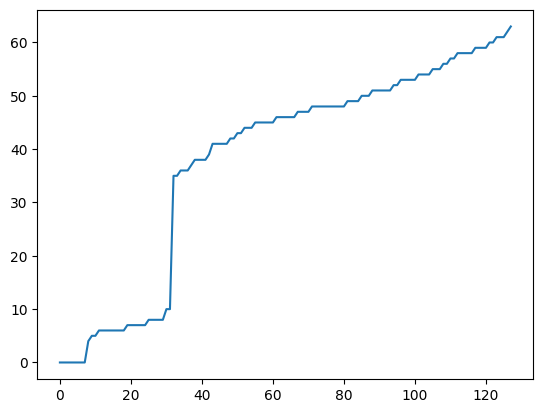

In [14]:
orthant_counts = torch.zeros(128)
for x in X_training:
    orthant_counts[find_orthant(x)] += 1
plt.plot(range(128), torch.sort(orthant_counts).values)

In [15]:
X_training_flip = torch.clone(X_training)
# Y_training_flip = torch.tensor([Y_training[i] * FLIP_MULS[find_orthant(X_training[i])] for i in range(len(Y_training))]).reshape(-1, 1)
Y_training_flip = torch.tensor([Y_training[i] if FLIP_MULS[find_orthant(X_training[i])] == 1 else 1-Y_training[i] for i in range(len(Y_training))]).reshape(-1, 1)
X_training_flip.shape, Y_training_flip.shape

(torch.Size([4873, 7]), torch.Size([4873, 1]))

In [16]:
# ZERO_ORTHANT_INDICES = [find_orthant(orthant) for orthant in ZERO_ORTHANTS]
# LOW_ORTHANT_INDICES = [find_orthant(orthant) for orthant in LOW_ORTHANTS]
# HIGH_ORTHANT_INDICES = [find_orthant(orthant) for orthant in HIGH_ORTHANTS]

#### Train-Validation split

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=0.2)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([3898, 7]),
 torch.Size([975, 7]),
 torch.Size([3898, 1]),
 torch.Size([975, 1]))

In [18]:
X_train_flip, X_val_flip, Y_train_flip, Y_val_flip = train_test_split(X_training_flip, Y_training_flip, test_size=0.2)
X_train_flip.shape, X_val_flip.shape, Y_train_flip.shape, Y_val_flip.shape

(torch.Size([3898, 7]),
 torch.Size([975, 7]),
 torch.Size([3898, 1]),
 torch.Size([975, 1]))

#### Test data

In [19]:
X_test = torch.cat([
    torch.cat([
        torch.cat([
            generate_point(1, orthant).reshape(1, -1) for i in range(TEST_COUNT)
        ]),
        torch.cat([
            generate_point(2, orthant).reshape(1, -1) for i in range(TEST_COUNT)
        ])
    ]).reshape(1, 2*TEST_COUNT, 7) for orthant in ORTHANTS
])
Y_test = torch.cat([
    torch.cat([
        torch.zeros(TEST_COUNT, 1),
        torch.ones(TEST_COUNT, 1)
    ]).reshape(1, 2*TEST_COUNT, 1) for orthant in ORTHANTS
])
X_test.shape, Y_test.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

In [20]:
X_test_flip = torch.clone(X_test)
# Y_test_flip = torch.cat([(Y_test[i] * FLIP_MULS[i]).reshape(1, 128, 1) for i in range(len(Y_test))])
Y_test_flip = torch.cat([(Y_test[i] if FLIP_MULS[i] == 1 else 1 - Y_test[i]).reshape(1, 2*TEST_COUNT, 1) for i in range(len(Y_test))])
X_test_flip.shape, Y_test_flip.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

#### Data for hyperparameter tuning

In [21]:
from sklearn.utils import resample

X_train_cv, Y_train_cv = resample(X_train, Y_train, replace=False, n_samples=len(X_train)//5)
X_val_cv, Y_val_cv = resample(X_val, Y_val, replace=False, n_samples=len(X_val)//5)
X_train_cv.shape, X_val_cv.shape, Y_train_cv.shape, Y_val_cv.shape

(torch.Size([779, 7]),
 torch.Size([195, 7]),
 torch.Size([779, 1]),
 torch.Size([195, 1]))

In [22]:
X_train_flip_cv, Y_train_flip_cv = resample(X_train_flip, Y_train_flip, replace=False, n_samples=len(X_train_flip)//5)
X_val_flip_cv, Y_val_flip_cv = resample(X_val_flip, Y_val_flip, replace=False, n_samples=len(X_val_flip)//5)
X_train_flip_cv.shape, X_val_flip_cv.shape, Y_train_flip_cv.shape, Y_val_flip_cv.shape

(torch.Size([779, 7]),
 torch.Size([195, 7]),
 torch.Size([779, 1]),
 torch.Size([195, 1]))

## Neural network

In [23]:
device = 'cpu'

In [24]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(
        self,
        hidden_layers: int = 2,
        hidden_units: int = 32
    ) -> None:
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_units),
            nn.ReLU()
        )
        self.hidden = nn.Sequential()
        for i in range(hidden_layers):
            self.hidden.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            self.hidden.append(nn.ReLU())
        self.output = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.output(self.hidden(self.input(x)))


In [25]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)
train_cv_dataloader, val_cv_dataloader = make_dataloader(X_train_cv, Y_train_cv, batch_size=32, shuffle=True), make_dataloader(X_val_cv, Y_val_cv, batch_size=32, shuffle=True)
train_flip_dataloader, val_flip_dataloader = make_dataloader(X_train_flip, Y_train_flip, batch_size=32, shuffle=True), make_dataloader(X_val_flip, Y_val_flip, batch_size=32, shuffle=True)
train_flip_cv_dataloader, val_flip_cv_dataloader = make_dataloader(X_train_flip_cv, Y_train_flip_cv, batch_size=32, shuffle=True), make_dataloader(X_val_flip_cv, Y_val_flip_cv, batch_size=32, shuffle=True)

In [26]:
depths = [1, 2, 3, 4, 5]
widths = [16, 32, 64]
lambdas = [0, 1e-6, 1e-5, 1e-4]
etas = [1e-2, 1e-3, 1e-4]
betass = [(0.9, 0.999), (0.8, 0.9)]

### Without class flipping

In [27]:
best_depth = None
best_width = None
best_lambda = None
best_eta = None
best_betas = None
best_score = -1

In [28]:
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.test import predict

count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_cv_dataloader,
                        val_dataloader=val_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_lambda = lambda_i
                        best_eta = eta
                        best_betas = betas

print(f'Results:\nDepth: {best_depth}\nWidth: {best_width}\nLambda: {best_lambda}\nEta: {best_eta}\nBetas: {best_betas}\nAccuracy after {EPOCHS} epochs: {best_score}')

Model 1 of 360 trained. Validation accuracy: 0.550595223903656
Model 2 of 360 trained. Validation accuracy: 0.5327380895614624
Model 3 of 360 trained. Validation accuracy: 0.5416666865348816
Model 4 of 360 trained. Validation accuracy: 0.5416666865348816
Model 5 of 360 trained. Validation accuracy: 0.4851190447807312
Model 6 of 360 trained. Validation accuracy: 0.375
Model 7 of 360 trained. Validation accuracy: 0.5639880895614624
Model 8 of 360 trained. Validation accuracy: 0.550595223903656
Model 9 of 360 trained. Validation accuracy: 0.6026785969734192
Model 10 of 360 trained. Validation accuracy: 0.555059552192688
Model 11 of 360 trained. Validation accuracy: 0.5461309552192688
Model 12 of 360 trained. Validation accuracy: 0.4806547462940216
Model 13 of 360 trained. Validation accuracy: 0.4985118806362152
Model 14 of 360 trained. Validation accuracy: 0.4851190447807312
Model 15 of 360 trained. Validation accuracy: 0.5416666865348816
Model 16 of 360 trained. Validation accuracy: 0.61

In [29]:
best_model_nn = SimpleNN(hidden_layers=best_depth, hidden_units=best_width).to(device)

In [30]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, betas=best_betas, weight_decay=best_lambda)
metric = BinaryAccuracy()

In [31]:
from scripts.utils import EarlyStopping

early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [32]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.696978, Train score: 0.502029, Val loss: 0.716274, Val score: 0.511290
Epoch: 2 => Train loss: 0.695664, Train score: 0.500039, Val loss: 0.694005, Val score: 0.491129
Epoch: 3 => Train loss: 0.694157, Train score: 0.496867, Val loss: 0.695655, Val score: 0.492003
Epoch: 4 => Train loss: 0.693710, Train score: 0.506601, Val loss: 0.695073, Val score: 0.486828
Epoch: 5 => Train loss: 0.693625, Train score: 0.516531, Val loss: 0.695714, Val score: 0.481250
Epoch: 6 => Train loss: 0.693578, Train score: 0.517418, Val loss: 0.699713, Val score: 0.468683
Epoch: 7 => Train loss: 0.692678, Train score: 0.519132, Val loss: 0.697140, Val score: 0.492608
Epoch: 8 => Train loss: 0.692359, Train score: 0.518127, Val loss: 0.695859, Val score: 0.497648
Epoch: 9 => Train loss: 0.685965, Train score: 0.541279, Val loss: 0.689041, Val score: 0.529436
Epoch: 10 => Train loss: 0.677195, Train score: 0.548865, Val loss: 0.68

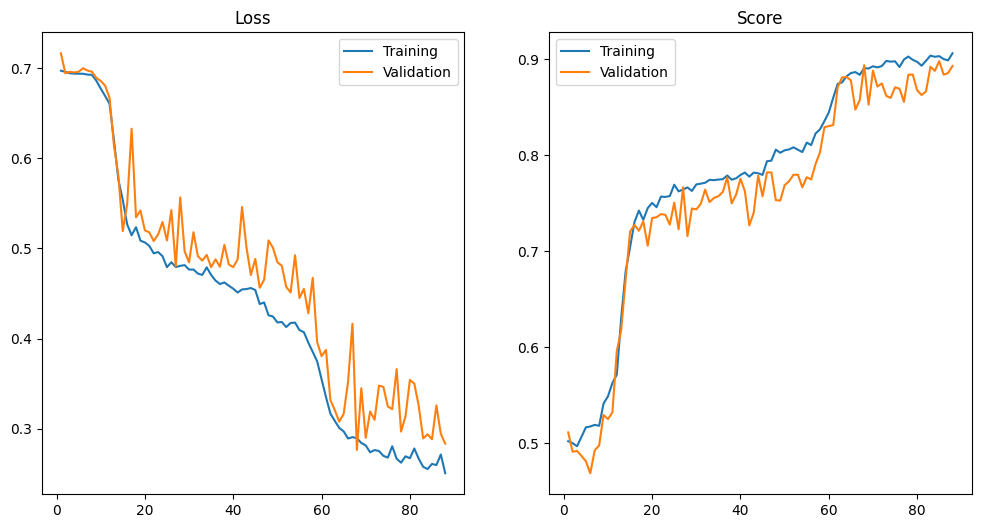

In [33]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [34]:
from scripts.test import predict

scores_nn = torch.tensor([
    metric(
        predict(best_model_nn, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

### With class flipping in random orthants

In [35]:
best_depth_flip = None
best_width_flip = None
best_lambda_flip = None
best_eta_flip = None
best_betas_flip = None
best_score_flip = -1

In [38]:
count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_flip_cv_dataloader,
                        val_dataloader=val_flip_cv_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score_flip:
                        best_score_flip = score
                        best_depth_flip = depth
                        best_width_flip = width
                        best_lambda_flip = lambda_i
                        best_eta_flip = eta
                        best_betas_flip = betas

print(f'Results:\nDepth: {best_depth_flip}\nWidth: {best_width_flip}\nLambda: {best_lambda_flip}\nEta: {best_eta_flip}\nBetas: {best_betas_flip}\nAccuracy after {EPOCHS} epochs: {best_score_flip}')

Model 1 of 360 trained. Validation accuracy: 0.5029761791229248
Model 2 of 360 trained. Validation accuracy: 0.4672618806362152
Model 3 of 360 trained. Validation accuracy: 0.4538690447807312
Model 4 of 360 trained. Validation accuracy: 0.462797611951828
Model 5 of 360 trained. Validation accuracy: 0.4151785671710968
Model 6 of 360 trained. Validation accuracy: 0.507440447807312
Model 7 of 360 trained. Validation accuracy: 0.5282738208770752
Model 8 of 360 trained. Validation accuracy: 0.4583333134651184
Model 9 of 360 trained. Validation accuracy: 0.4895833134651184
Model 10 of 360 trained. Validation accuracy: 0.4925595223903656
Model 11 of 360 trained. Validation accuracy: 0.5580357313156128
Model 12 of 360 trained. Validation accuracy: 0.4196428656578064
Model 13 of 360 trained. Validation accuracy: 0.4761904776096344
Model 14 of 360 trained. Validation accuracy: 0.5208333134651184
Model 15 of 360 trained. Validation accuracy: 0.4672618806362152
Model 16 of 360 trained. Validation 

In [39]:
best_model_flip_nn = SimpleNN(hidden_layers=best_depth_flip, hidden_units=best_width_flip).to(device)

In [40]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model_flip_nn.parameters(), lr=best_eta_flip, betas=best_betas_flip, weight_decay=best_lambda_flip)
metric = BinaryAccuracy()

In [41]:
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [42]:
history = train_model(
    model=best_model_flip_nn,
    train_dataloader=train_flip_dataloader,
    val_dataloader=val_flip_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.693364, Train score: 0.501793, Val loss: 0.693354, Val score: 0.498925
Epoch: 2 => Train loss: 0.692841, Train score: 0.509221, Val loss: 0.694070, Val score: 0.483065
Epoch: 3 => Train loss: 0.692152, Train score: 0.518186, Val loss: 0.693981, Val score: 0.506519
Epoch: 4 => Train loss: 0.691272, Train score: 0.526758, Val loss: 0.695071, Val score: 0.501075
Epoch: 5 => Train loss: 0.690293, Train score: 0.530718, Val loss: 0.694318, Val score: 0.506989
Epoch: 6 => Train loss: 0.688823, Train score: 0.541555, Val loss: 0.694966, Val score: 0.517339
Epoch: 7 => Train loss: 0.686787, Train score: 0.543407, Val loss: 0.694778, Val score: 0.516935
Epoch: 8 => Train loss: 0.684960, Train score: 0.555702, Val loss: 0.706781, Val score: 0.499059
Epoch: 9 => Train loss: 0.683168, Train score: 0.552963, Val loss: 0.698113, Val score: 0.517473
Epoch: 10 => Train loss: 0.682411, Train score: 0.563840, Val loss: 0.70

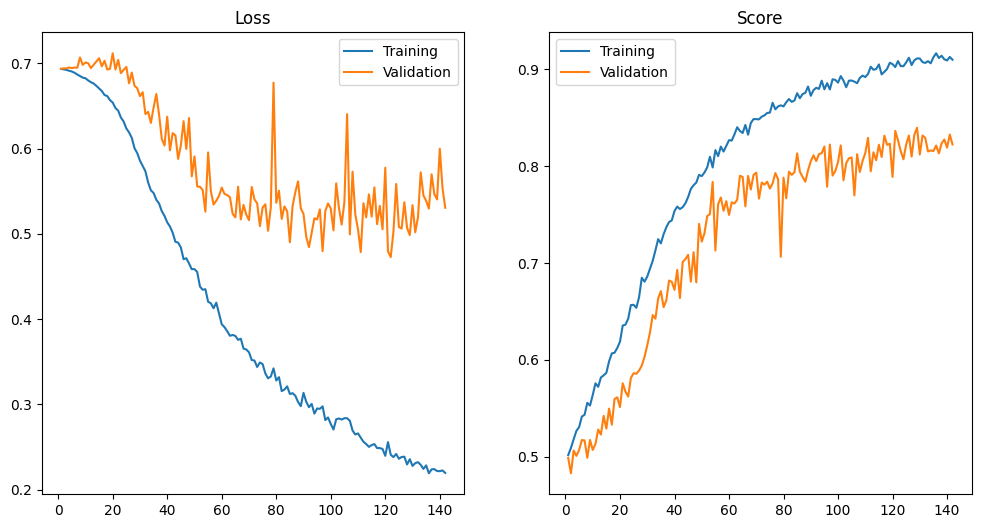

In [43]:
plot_train_history(history)

In [44]:
scores_flip_nn = torch.tensor([
    metric(
        predict(best_model_flip_nn, X_test_flip[i], device),
        Y_test_flip[i]
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, NN')

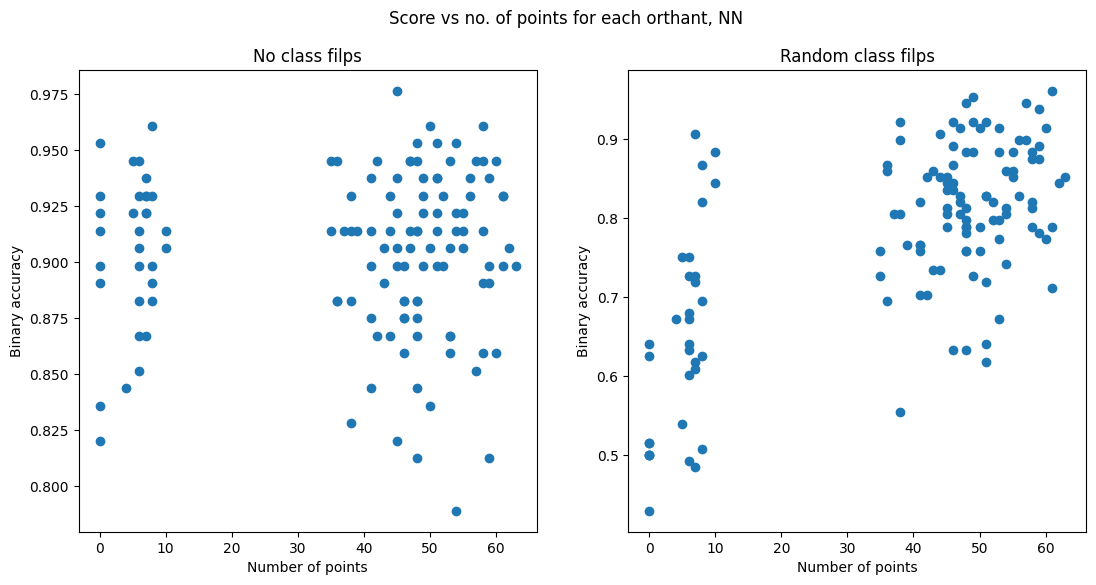

In [45]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('No class filps')

plt.subplot(122)
plt.scatter(orthant_counts, scores_flip_nn)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Random class filps')

plt.suptitle('Score vs no. of points for each orthant, NN')

In [46]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_nn).statistic, pearsonr(orthant_counts, scores_flip_nn).statistic

(0.004157272030579041, 0.6532355650367617)

In [47]:
scores_nn.mean(), scores_flip_nn.mean()

(tensor(0.9041), tensor(0.7741))

In [48]:
print('Performance in empty orthants: ', scores_nn[ZERO_ORTHANT_INDICES].mean(), scores_flip_nn[ZERO_ORTHANT_INDICES].mean())
print('Performance in rare orthants: ', scores_nn[LOW_ORTHANT_INDICES].mean(), scores_flip_nn[LOW_ORTHANT_INDICES].mean())
print('Performance in typical orthants: ', scores_nn[HIGH_ORTHANT_INDICES].mean(), scores_flip_nn[HIGH_ORTHANT_INDICES].mean())

Performance in empty orthants:  tensor(0.8955) tensor(0.5283)
Performance in rare orthants:  tensor(0.9082) tensor(0.6859)
Performance in typical orthants:  tensor(0.9038) tensor(0.8167)


Okay, maybe a neural network can find symmetry? Can an SVM do this too? Is the test data too similar to training?

## SVM

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [50]:
ntk = NTK(best_model_nn).get_ntk

In [51]:
model_base = SVC(kernel=ntk)
params = {
    'C': np.logspace(-5, 5, 11)
}
scorer = make_scorer(accuracy_score)

### Without class flipping

In [52]:
model_cv = GridSearchCV(
    estimator=model_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv.fit(X_train_cv, Y_train_cv.squeeze())
best_params = model_cv.best_params_
best_params

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 2/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 3/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 5/5] END ...........................C=1e-05;, score=0.516 total time=   1.1s
[CV 4/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 2/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 3/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 1/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 4/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 5/5] END ..........................C=0.0001;, score=0.516 total time=   1.1s
[CV 1/5] END ...........................C=0.001;, score=0.513 total time=   1.1s
[CV 2/5] END ...........................C=0.001;

{'C': 1.0}

In [53]:
best_model_km = SVC(C=best_params['C'], kernel=ntk)

In [54]:
best_model_km.fit(X_train, Y_train.squeeze())

SVC(kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f85e8137b20>>)

In [55]:
preds_train, preds_val = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.9443304258594151, 0.9015384615384615)

In [56]:
scores_km = np.array([
    accuracy_score(
        best_model_km.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

### With class flipping in random orthants

In [57]:
model_cv = GridSearchCV(
    estimator=model_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv.fit(X_train_flip_cv, Y_train_flip_cv.squeeze())
best_params_flip = model_cv.best_params_
best_params_flip

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 2/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 1/5] END ...........................C=1e-05;, score=0.513 total time=   1.1s
[CV 3/5] END ...........................C=1e-05;, score=0.506 total time=   1.1s
[CV 5/5] END ...........................C=1e-05;, score=0.510 total time=   1.1s
[CV 4/5] END ...........................C=1e-05;, score=0.506 total time=   1.1s
[CV 1/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 2/5] END ..........................C=0.0001;, score=0.513 total time=   1.1s
[CV 3/5] END ..........................C=0.0001;, score=0.506 total time=   1.2s
[CV 4/5] END ..........................C=0.0001;, score=0.506 total time=   1.2s
[CV 5/5] END ..........................C=0.0001;, score=0.510 total time=   1.2s
[CV 2/5] END ...........................C=0.001;, score=0.513 total time=   1.2s
[CV 3/5] END ...........................C=0.001;

{'C': 10.0}

In [58]:
best_model_flip_km = SVC(C=best_params_flip['C'], kernel=ntk)

In [59]:
best_model_flip_km.fit(X_train_flip, Y_train_flip.squeeze())

SVC(C=10.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f85e8137b20>>)

In [60]:
preds_train, preds_val = best_model_flip_km.predict(X_train_flip), best_model_flip_km.predict(X_val_flip)
score_train, score_val = accuracy_score(Y_train_flip.squeeze(), preds_train), accuracy_score(Y_val_flip.squeeze(), preds_val)
score_train, score_val

(0.7878399179066188, 0.7394871794871795)

In [61]:
scores_flip_km = np.array([
    accuracy_score(
        best_model_flip_km.predict(X_test_flip[i]),
        Y_test_flip[i].squeeze()
    ) for i in range(128)
])

### Orthant performance plot

Text(0.5, 0.98, 'Score vs no. of points for each orthant, SVM')

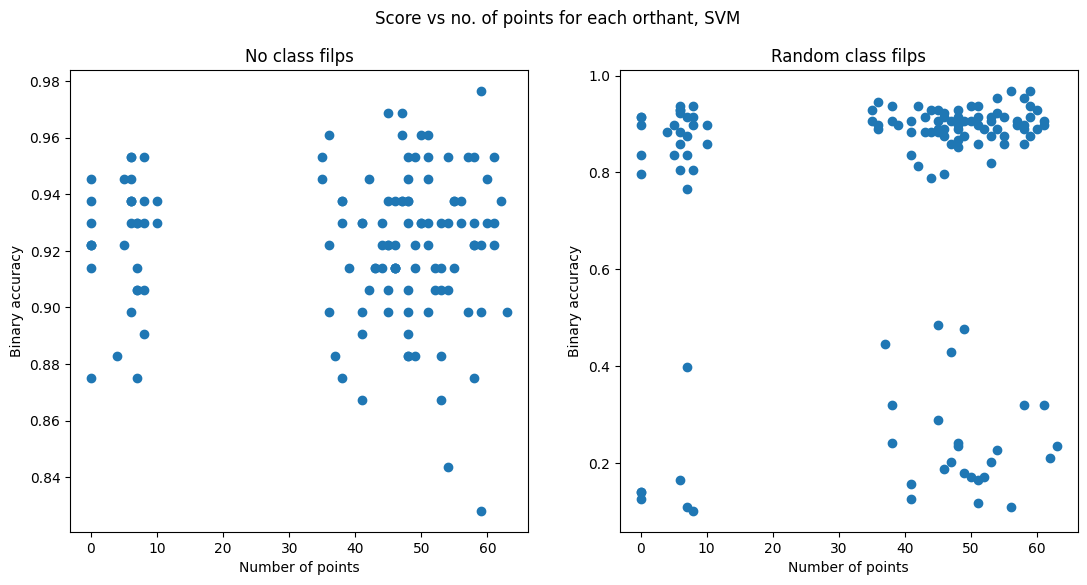

In [62]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.scatter(orthant_counts, scores_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('No class filps')

plt.subplot(122)
plt.scatter(orthant_counts, scores_flip_km)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Random class filps')

plt.suptitle('Score vs no. of points for each orthant, SVM')

In [63]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores_km).statistic, pearsonr(orthant_counts, scores_flip_km).statistic

(-0.030811604277895026, 0.012572953018726768)

In [64]:
scores_km.mean(), scores_flip_km.mean()

(0.9219970703125, 0.72784423828125)

In [65]:
print('Performance in empty orthants: ', scores_km[ZERO_ORTHANT_INDICES].mean(), scores_flip_km[ZERO_ORTHANT_INDICES].mean())
print('Performance in rare orthants: ', scores_km[LOW_ORTHANT_INDICES].mean(), scores_flip_km[LOW_ORTHANT_INDICES].mean())
print('Performance in typical orthants: ', scores_km[HIGH_ORTHANT_INDICES].mean(), scores_flip_km[HIGH_ORTHANT_INDICES].mean())

Performance in empty orthants:  0.9208984375 0.595703125
Performance in rare orthants:  0.9244791666666666 0.7649739583333334
Performance in typical orthants:  0.9214680989583334 0.7295735677083334
